In [1]:
import numpy as np
import matplotlib.pyplot as plt

import simtk.unit as unit
from simtk import openmm as mm
from simtk.openmm import app

from tqdm import tqdm

# 2D Lennard-Jones fluid

In [2]:
n_particles = 1
mass = 39.948 * unit.amu
l_box = 500.0 * unit.angstroms

with_LJ = True
sigma = 3.404 * unit.angstroms
epsilon = 0.238 * unit.kilocalories_per_mole
charge = 0.0 * unit.elementary_charge

with_spring = True
k=1.0*unit.kilocalories_per_mole/unit.nanometers**2

In [3]:
temperature = 300.00 * unit.kelvin
integration_timestep = 0.002 * unit.picoseconds
collisions_rate = 1.0 / unit.picoseconds

production_time = 100.0 * unit.picoseconds
saving_time = 0.1 * unit.picoseconds

In [4]:
system = mm.System()
_ = system.addParticle(mass)

In [5]:
v1 = np.zeros(3) * unit.angstroms
v2 = np.zeros(3) * unit.angstroms
v3 = np.zeros(3) * unit.angstroms

v1[0] = l_box
v2[1] = l_box
v3[2] = l_box

system.setDefaultPeriodicBoxVectors(v1, v2, v3)

In [6]:
if with_LJ:
    non_bonded_force = mm.NonbondedForce()
    non_bonded_force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
    non_bonded_force.setCutoffDistance(4.0*sigma)
    non_bonded_force.setUseSwitchingFunction(True)
    non_bonded_force.setSwitchingDistance(3.0*sigma)
    non_bonded_force.setUseDispersionCorrection(True)
    non_bonded_force.addParticle(charge, sigma, epsilon)
    _ = system.addForce(non_bonded_force)

In [7]:
if with_spring:
    force = mm.CustomExternalForce('A*(z^2)')
    force.addGlobalParameter('A', 0.5*k)
    force.addParticle(0, [])
    _ = system.addForce(force)

In [8]:
integrator = mm.LangevinIntegrator(temperature, collisions_rate, integration_timestep)

platform = mm.Platform.getPlatformByName('CPU')

context = mm.Context(system, integrator, platform)

In [9]:
initial_positions=np.zeros([1,3])*unit.angstroms
initial_velocities=np.zeros([1,3])*unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [10]:
production_n_steps = int(production_time/integration_timestep)
saving_n_steps = int(saving_time/integration_timestep)
n_saving_periods = int(production_n_steps/saving_n_steps)

time = np.zeros([n_saving_periods+1]) * unit.nanoseconds
trajectory = np.zeros([n_saving_periods+1, n_particles, 3]) * unit.angstroms
velocities = np.zeros([n_saving_periods+1, n_particles, 3]) * unit.angstroms/unit.picoseconds
potential_energy = np.zeros([n_saving_periods+1]) * unit.kilocalories_per_mole
kinetic_energy = np.zeros([n_saving_periods+1]) * unit.kilocalories_per_mole

state = context.getState(getPositions=True, getVelocities=True,
                         getEnergy=True, enforcePeriodicBox = False)
time[0] = state.getTime()
trajectory[0,:,:] = state.getPositions(asNumpy=True)
velocities[0,:,:] = state.getVelocities(asNumpy=True)
potential_energy[0] = state.getPotentialEnergy()
kinetic_energy[0] = state.getKineticEnergy()

for ii in tqdm(range(1,n_saving_periods+1)):
    integrator.step(saving_n_steps)
    state = context.getState(getPositions=True, getVelocities=True,
                             getEnergy=True, enforcePeriodicBox = False)
    time[ii] = state.getTime()
    trajectory[ii,:,:] = state.getPositions(asNumpy=True)
    velocities[ii,:,:] = state.getVelocities(asNumpy=True)
    potential_energy[ii] = state.getPotentialEnergy()
    kinetic_energy[ii] = state.getKineticEnergy()

100%|██████████| 1000/1000 [01:05<00:00, 15.31it/s]


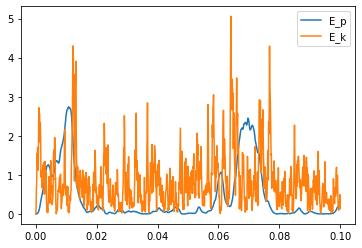

In [11]:
plt.plot(time, potential_energy, label='E_p')
plt.plot(time, kinetic_energy, label='E_k')
plt.legend()
plt.show()

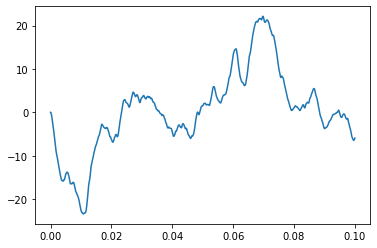

In [12]:
plt.plot(time, trajectory[:,:,2])

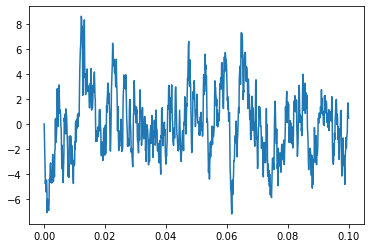

In [13]:
plt.plot(time, velocities[:,:,2])

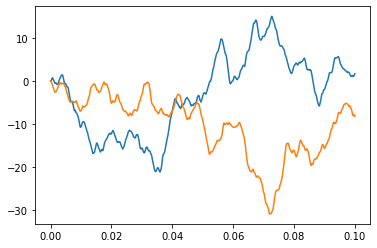

In [14]:
plt.plot(time, trajectory[:,:,0])
plt.plot(time, trajectory[:,:,1])

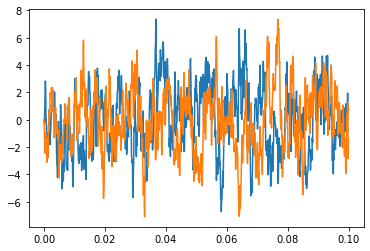

In [15]:
plt.plot(time, velocities[:,:,0])
plt.plot(time, velocities[:,:,1])